<a href="https://colab.research.google.com/github/matsuda-tkm/artist-prediction-xai/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
学習済みのモデルを使って、歌詞からアーティスト名の予測＆LIMEによる解釈を可視化します。

# 準備

In [1]:
%%capture
!pip install japanize-matplotlib
!pip install lime
!pip install janome

In [2]:
!git clone https://github.com/matsuda-tkm/artist-prediction-xai.git

Cloning into 'artist-prediction-xai'...
remote: Enumerating objects: 874, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 874 (delta 17), reused 281 (delta 16), pack-reused 592
Receiving objects: 100% (874/874), 427.85 MiB | 31.99 MiB/s, done.
Resolving deltas: 100% (267/267), done.
Updating files: 100% (216/216), done.


In [3]:
import os
import sys
import torch
import functools
from tqdm import tqdm
import japanize_matplotlib
from collections import OrderedDict
from IPython.display import display, HTML
from lime.lime_text import LimeTextExplainer

sys.path.append('/content/artist-prediction-xai')
from network import CharacterCNN, CharacterCNNClassifier, CharacterCNNEmbedding
from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
# 保存先のパス
PATH = '/content/artist-prediction-xai'

# 学習済みアーティスト一覧
for i,name in enumerate(os.listdir(os.path.join(PATH, 'models'))):
    print(f'{i:2} : {name}')

 0 : ヨルシカ
 1 : TWICE
 2 : King Gnu
 3 : ポルノグラフィティ
 4 : 三代目 J SOUL BROTHERS
 5 : いきものがかり
 6 : RADWIMPS
 7 : Perfume
 8 : Eve
 9 : GreeeeN
10 : back number
11 : 嵐
12 : Aimer
13 : BTS
14 : Uru
15 : B_z
16 : ONE OK ROCK
17 : 小田和正
18 : Official髭男dism
19 : 優里
20 : 安室奈美恵
21 : Ado
22 : ZARD
23 : Superfly
24 : 宇多田ヒカル
25 : スピッツ
26 : BUMP OF CHICKEN
27 : 椎名林檎
28 : 星野源
29 : SEKAI NO OWARI
30 : 米津玄師
31 : サザンオールスターズ
32 : あいみょん
33 : Mr.Children
34 : 中島みゆき
35 : 緑黄色社会
36 : ゆず
37 : 倖田來未
38 : YOASOBI
39 : aiko
40 : Mrs. GREEN APPLE


In [9]:
select_all = False #@param {type:"boolean"}

select_artist = dict()
select_id = [5,6,10,11,18,19,25,28,32,40]  #@param
for i,name in enumerate(os.listdir(os.path.join(PATH, 'models'))):
    select_artist[name] = True if (i in select_id) or select_all else False

print(f'You selected {sum(list(select_artist.values()))} artists.')
print([k for k,v in select_artist.items() if v])

You selected 10 artists.
['いきものがかり', 'RADWIMPS', 'back number', '嵐', 'Official髭男dism', '優里', 'スピッツ', '星野源', 'あいみょん', 'Mrs. GREEN APPLE']


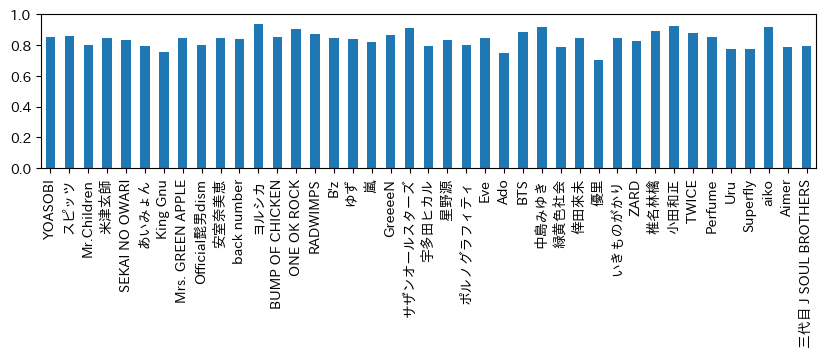

# モデルの読み込み

In [10]:
print('Loading models...')

# Embeddingの読み込み
state_dict = torch.load(os.path.join(PATH, 'pretrain/model_fold1.pth'), map_location=device)
state_dict = OrderedDict(list(state_dict.items())[0:1])
embed = CharacterCNNEmbedding().to(device)
embed.load_state_dict(state_dict)

# Classifierの読み込み
classifier = dict()
for artist in tqdm(os.listdir(os.path.join(PATH, 'models'))):
    if select_artist[artist]:
        model_list = []
        for file in os.listdir(os.path.join(PATH, 'models', artist)):
            state_dict = torch.load(os.path.join(PATH, 'models', artist, file), map_location=device)
            clf = CharacterCNNClassifier(2).to(device)
            clf.load_state_dict(state_dict)
            model_list.append(clf)
        classifier[artist] = model_list

artists = list(classifier.keys())
explainer = LimeTextExplainer(class_names=artists)

Loading models...


100%|██████████| 41/41 [00:00<00:00, 92.38it/s]


# 推論と解釈

## 1ブロック分の歌詞
- `txt`に歌詞1ブロック分を入力してください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍店の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。
- LIME表示用の分かち書きは自動生成されますが、`wakachi_txt`(カスタム分かち書き)に自分で分かち書きした歌詞も入れることができます。`txt`に入力した歌詞を**半角スペース**で分かち書きしたものを入れてください。

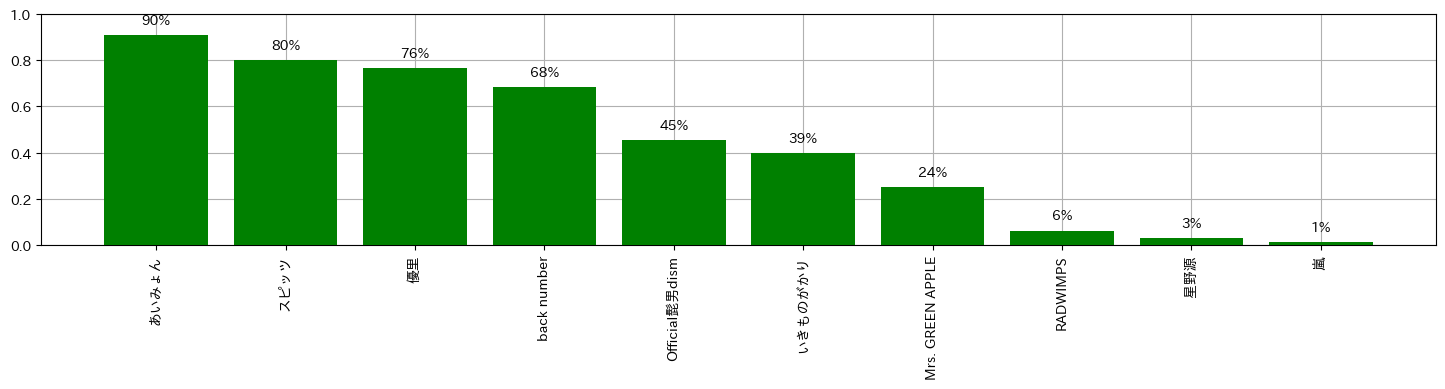

In [13]:
txt = """麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋"""

figsize = (18,3)  # グラフのサイズを調整 (横,縦)
num_samples = 100  # サンプルする近傍点の個数

# 分類結果の取得
prob = predict_one_block(txt, embed, classifier, device)
# 棒グラフで可視化
show_predict_one_block(prob, artists, sort=True, figsize=figsize)

# カスタム分かち書き ###############
wakachi_txt = """
"""

# LIME
if wakachi_txt == '\n':
    wakachi_txt = wakachi_one_block(txt)
predict_some_block_lime = functools.partial(predict_some_block,  embed=embed, classifier=classifier, device=device)
exp = explainer.explain_instance(wakachi_txt, predict_some_block_lime, num_features=len(wakachi_txt.split()), labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt, artists, sort_by=prob)
display(HTML(highlighted_text))

## 歌詞全体
- `txt`に歌詞全体を入力してください。ブロック間は改行を1つはさんでください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍点の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。

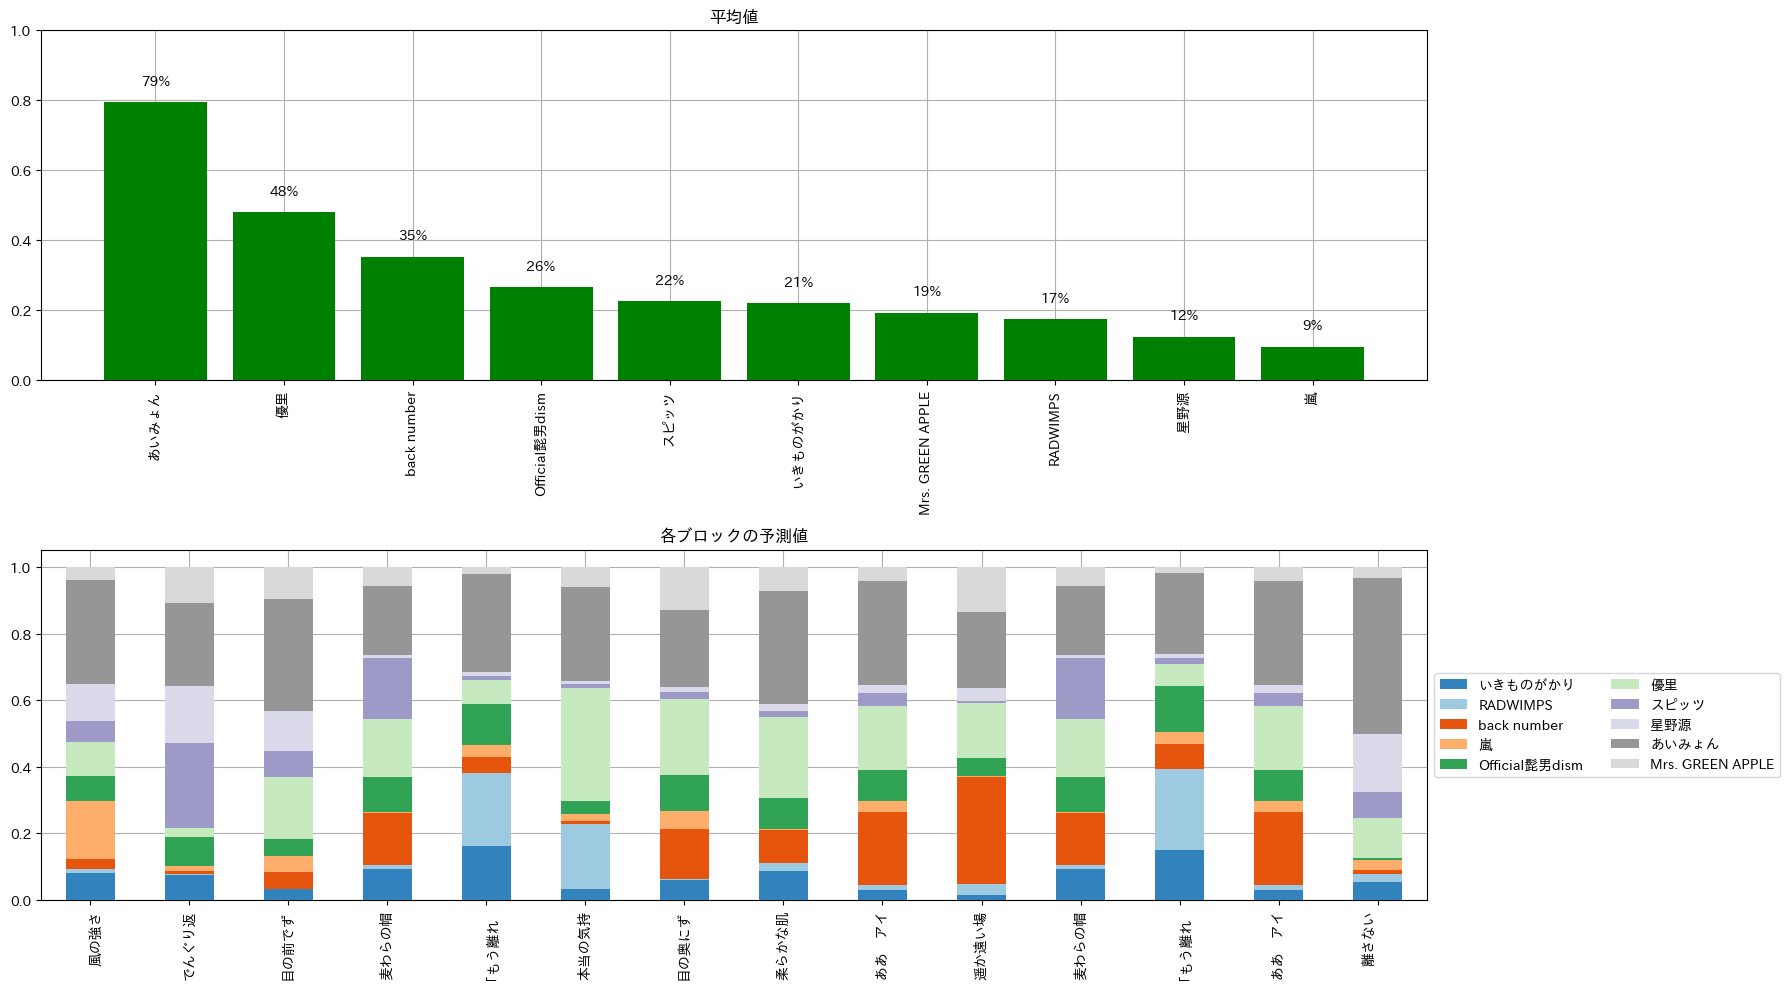

In [12]:
txt = """
風の強さがちょっと
心を揺さぶりすぎて
真面目に見つめた
君が恋しい

でんぐり返しの日々
可哀想なふりをして
だらけてみたけど
希望の光は

目の前でずっと輝いている
幸せだ

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて　抱きしめて　離さない

本当の気持ち全部
吐き出せるほど強くはない
でも不思議なくらいに
絶望は見えない

目の奥にずっと写るシルエット
大好きさ

柔らかな肌を寄せあい
少し冷たい空気を2人
かみしめて歩く今日という日に
何と名前をつけようかなんて話して

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

遥か遠い場所にいても
繋がっていたいなあ
2人の想いが
同じでありますように

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて離さない

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

離さない
いつまでも　いつまでも　離さない
"""
figsize = (18,10)  # グラフのサイズを調整 (横,縦)
num_samples = 100  # サンプルする近傍点の個数

# 分類結果の取得
prob = predict_some_block(txt.split('\n\n'), embed, classifier, device)

# 100%積み上げ棒グラフで可視化
show_predict_whole_song(prob, artists, sort=True, raw_txt_arr=txt.split('\n\n'), figsize=figsize)

# LIME
wakachi_txt = wakachi_some_block(txt)
predict_whole_song_lime = functools.partial(predict_whole_song, embed=embed, classifier=classifier, device=device)
exp = explainer.explain_instance(wakachi_txt, predict_whole_song_lime, num_features=len(wakachi_txt.split()), labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt, artists, sort_by=prob.mean(axis=0))
display(HTML(highlighted_text))